# Noise

In [65]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteState, RXXGate, HGate, Phase, XGate, Conditional
from squint.ops.noise import BitFlipChannel, DepolarizingChannel
from squint.ops.base import SharedGate
from squint.utils import print_nonzero_entries

In [66]:
dim = 2

n = 5
circuit = Circuit()
for i in range(n):
    circuit.add(DiscreteState(wires=(i,), n=(0,)))

circuit.add(HGate(wires=(0,)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

circuit.add(
    # SharedGate(op=BitFlipChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    SharedGate(op=DepolarizingChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    "noise",
)

circuit.add(
    SharedGate(op=Phase(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))


# circuit.add(
#     SharedGate(op=BitFlipChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
#     SharedGate(op=DepolarizingChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
#     "noise",
# )

params, static = eqx.partition(circuit, eqx.is_inexact_array)

get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])

pprint(params)
get(circuit)



Circuit(
  ops={
│   0:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   1:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   2:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   3:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   4:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   5:
│   HGate(wires=(None,)),
│   6:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   7:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   8:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   9:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   'noise':
│   SharedGate(
│     wires=(None, None, None, None, None),
│     op=DepolarizingChannel(wires=(None,), p=weak_f32[]),
│     copies=[
│   │   DepolarizingChannel(wires=(None,), p=None),
│   │   DepolarizingChannel(wires=(None,), p=None),
│   │   DepolarizingChannel(wires=(None,), p=None),
│   │   DepolarizingChannel(wires=(None,), p=None)
│     ],
│     where=None,
│     get=None
│   ),
│   'phase':
│   SharedGate(
│     wires=(None, None, None, None, None),
│     op=Phase(wires=(None,), phi=weak_f32[]),
│     copies=[
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None)
│     ],
│     where=None,
│     get=None
│   ),
│   12:
│   HGate(wires=(None,)),
│   13:
│   HGate(wires=(None,)),
│   14:
│   HGate(wires=(None,)),
│   15:
│   HGate(wires=(None,)),
│   16:
│   HGate(wires=(None,))
  }
)

Array([0.31415927], dtype=float32)

In [67]:
path = circuit.path(dim=dim)

sim = circuit.compile(params, static, dim=2).jit()
print_nonzero_entries(sim.prob.forward(params))
print(sim.prob.cfim(get, params))

Basis: [0 0 0 0 0], Value: 0.03125001862645149
Basis: [0 0 0 0 1], Value: 0.03125001862645149
Basis: [0 0 0 1 0], Value: 0.03125002235174179
Basis: [0 0 0 1 1], Value: 0.03125002607703209
Basis: [0 0 1 0 0], Value: 0.03125002235174179
Basis: [0 0 1 0 1], Value: 0.03125002607703209
Basis: [0 0 1 1 0], Value: 0.03125001862645149
Basis: [0 0 1 1 1], Value: 0.03125002980232239
Basis: [0 1 0 0 0], Value: 0.03125002235174179
Basis: [0 1 0 0 1], Value: 0.03125002607703209
Basis: [0 1 0 1 0], Value: 0.03125001862645149
Basis: [0 1 0 1 1], Value: 0.03125002980232239
Basis: [0 1 1 0 0], Value: 0.03125002235174179
Basis: [0 1 1 0 1], Value: 0.03125002980232239
Basis: [0 1 1 1 0], Value: 0.03125002980232239
Basis: [0 1 1 1 1], Value: 0.03125002607703209
Basis: [1 0 0 0 0], Value: 0.03125001862645149
Basis: [1 0 0 0 1], Value: 0.03125002235174179
Basis: [1 0 0 1 0], Value: 0.03125001862645149
Basis: [1 0 0 1 1], Value: 0.03125002607703209
Basis: [1 0 1 0 0], Value: 0.03125001862645149
Basis: [1 0 1

In [68]:
params = eqx.tree_at(
    lambda pytree: pytree.ops["noise"].op.p, params, 0.1
)
print(sim.prob.cfim(get, params))

[[5.9766903]]


In [73]:

# ps = jnp.linspace(0, 0.5, 50)
ps = jnp.logspace(-10, jnp.log10(0.05), 50)
print(ps)
params = eqx.tree_at(
    lambda pytree: pytree.ops["noise"].op.p, params, ps
)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params, jnp.ones_like(ps) * 0.01
)
# print(params)
# probs = eqx.filter_vmap(sim.prob.forward)(params)
cfims = eqx.filter_vmap(sim.prob.cfim, in_axes=(None, 0))(get, params)

[1.00000001e-10 1.50497850e-10 2.26495531e-10 3.40870887e-10
 5.13003362e-10 7.72058972e-10 1.16192966e-09 1.74867909e-09
 2.63171862e-09 3.96067978e-09 5.96073768e-09 8.97078234e-09
 1.35008191e-08 2.03184207e-08 3.05787502e-08 4.60203111e-08
 6.92595776e-08 1.04234175e-07 1.56870016e-07 2.36085739e-07
 3.55303968e-07 5.34724222e-07 8.04747572e-07 1.21112782e-06
 1.82272129e-06 2.74315312e-06 4.12838199e-06 6.21311938e-06
 9.35061053e-06 1.40724524e-05 2.11787374e-05 3.18735110e-05
 4.79688933e-05 7.21921533e-05 1.08647575e-04 1.63512173e-04
 2.46082025e-04 3.70347960e-04 5.57365420e-04 8.38821987e-04
 1.26240833e-03 1.89989642e-03 2.85930163e-03 4.30318480e-03
 6.47619367e-03 9.74652637e-03 1.46683045e-02 2.20754705e-02
 3.32230888e-02 5.00000082e-02]


In [74]:
print(cfims.squeeze())

[25.003365   25.003365   25.003365   25.003365   25.003365   25.003365
 25.003365   25.003365   25.003365   25.003365   25.003365   25.003365
 25.003365   25.003365   25.00036    24.999172   24.999172   24.987244
 24.976503   24.970558   24.952108   24.934853   24.882145   24.833157
 24.7632     24.644869   24.456581   24.201561   23.817684   23.250471
 22.462431   21.366745   19.902168   18.039661   15.8159685  13.343462
 10.794236    8.38403     6.2702804   4.541442    3.2045443   2.2155168
  1.507181    1.0117046   0.6708045   0.43902314  0.28273913  0.1780776
  0.10848206  0.06269487]


[Text(0.5, 0, 'Noise coefficient, $p$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 None]

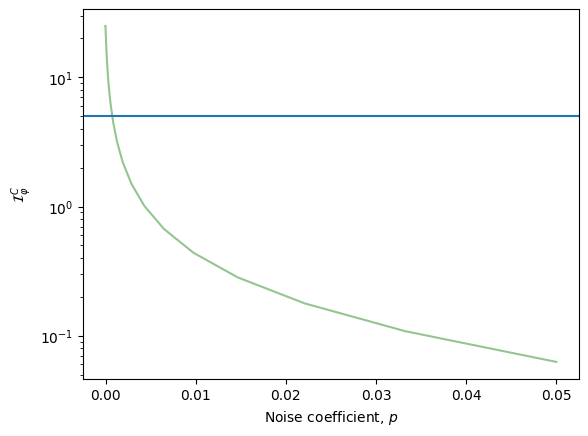

In [75]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
# fig, ax = plt.subplots()
# for i, idx in enumerate(
#     itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
# ):
#     ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
# ax.legend()
# ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(ps, cfims.squeeze(), color=colors[0])
ax.axhline(n)
ax.set(
    # xlabel=r"Phase, $\varphi$",
    xlabel=r"Noise coefficient, $p$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    # ylim=[0, 1.05 * jnp.max(cfims)],
    yscale='log'
)

# fig, ax = plt.subplots()
# ax.plot(phis, cfims.squeeze(), color=colors[i])
# ax.set(
#     xlabel=r"Phase, $\varphi$",
#     ylabel=r"$\mathcal{I}_\varphi^C$",
#     ylim=[0, 1.05 * jnp.max(cfims)],
# )